In [1]:
pip install pandas

Note: you may need to restart the kernel to use updated packages.


In [146]:
pip install numpy

In [6]:
pip install psycopg2

In [3]:
import psycopg2
import pandas as pd


try:
    # Подключение к БД
    connection = psycopg2.connect(
        host='127.0.0.1', # '127.0.0.1'
        user='postgres', # 'postgres'
        password='qwerty', # 'qwerty'
        database='practice2023', # 'practice2023'
    )

    cursor = connection.cursor()
    
    # Проверка существования таблицы в БД
    cursor.execute("select * from information_schema.tables where table_name=%s", ('dop_results',))
    answer = bool(cursor.rowcount)

    if answer is False:
        create_table(cursor, connection)
        print('[INFO] Таблица создана!')

    else:
        print('[INFO] Таблица уже существует в PostgreSQL')
    
    # Создание запроса с последующим преобразованием query в Dataframe
    query = """SELECT id_stand, id_test, id_version, input_rate, ierrors, id_runs FROM dop_results"""
    data = pd.read_sql_query(query, connection)
    
except Exception as _ex:
    print('[INFO] Error while working with PostgreSQL', _ex)

finally:
    # Отключение от БД
    if connection:
        connection.close()
        print('[INFO] PostgreSQL connection closed')
        


[INFO] Таблица уже существует в PostgreSQL
[INFO] PostgreSQL connection closed


In [20]:
# Удалим собранные с ошибкой прогоны 
data.drop(data[data['id_runs'].isin([85, 151])].index, inplace=True)
data['errors_rate'] = data['ierrors'] / (data['ierrors'] + data['input_rate']) * 100

In [9]:
pip install sklearn

Note: you may need to restart the kernel to use updated packages.


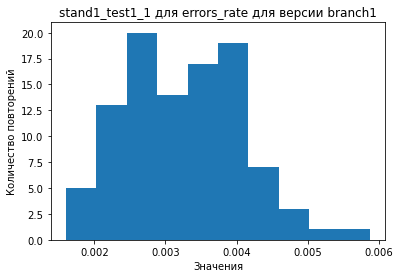

Тест Колмогорова-Смирнова для нормального з.р.:
Распределение данных похоже на нормальное


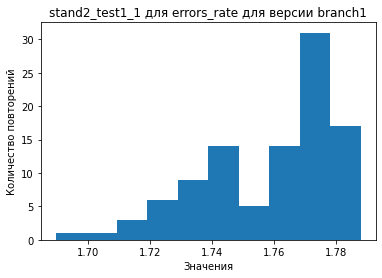

Тест Колмогорова-Смирнова для нормального з.р.:
Распределение данных похоже на нормальное


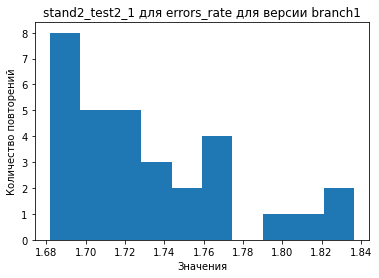

Тест Колмогорова-Смирнова для нормального з.р.:
Распределение данных похоже на нормальное


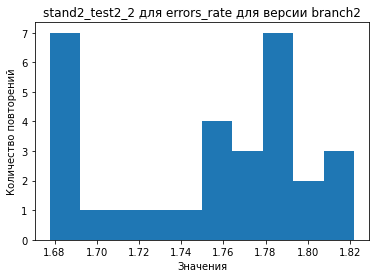

Тест Колмогорова-Смирнова для нормального з.р.:
Распределение данных похоже на нормальное


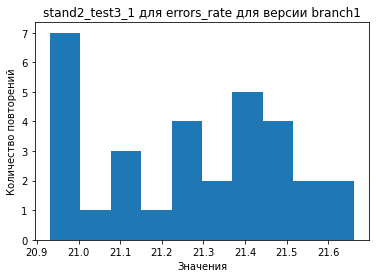

Тест Колмогорова-Смирнова для нормального з.р.:
Распределение данных похоже на нормальное


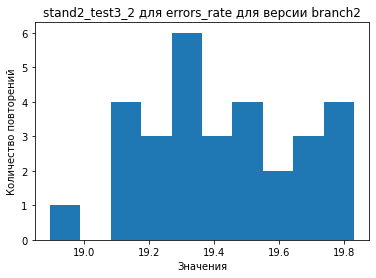

Тест Колмогорова-Смирнова для нормального з.р.:
Распределение данных похоже на нормальное


In [21]:
"""Фильтрация данных по версии стенда и различных тестов"""

from scipy.stats import kstest, lognorm, norm
import matplotlib.pyplot as plt

def test_func(stack):

    # Выполнение теста Колмогорова-Смирнова
    statistic, p_value = kstest(stack['errors_rate'], norm.fit(stack['errors_rate']))
    print("Тест Колмогорова-Смирнова для нормального з.р.:")
    alpha = 0.05
    if p_value > alpha:
        print("Распределение данных похоже на нормальное")
    else:
        print("Распределение данных не является нормальным")

master = 'branch1'
distribute = 'branch2'
grouped_data = data.groupby(['id_stand', 'id_test', 'id_version'])

stands = ['stand1', 'stand2']
versions = [master, distribute]
test = [1,2,3]
stack_df = []
for i in stands:
    for j in test:
        for k in versions:
            try:
                df = grouped_data.get_group((i, j, k))
                stack_df.append(df)
            except Exception as ex:
                continue
                

name_df = ['stand1_test1_1' ,'stand2_test1_1', 'stand2_test2_1', 'stand2_test2_2', 'stand2_test3_1', 'stand2_test3_2']
k = 0

for i in stack_df:
    plt.hist(i['errors_rate'])

    if (name_df[k] == 'stand2_test1_1' 
        or name_df[k] ==  'stand2_test2_1'
        or name_df[k] == 'stand2_test3_1'
        or name_df[k] == 'stand1_test1_1'):
        
        plt.title(f'{name_df[k]} для errors_rate для версии branch1')
    else:
        plt.title(f'{name_df[k]} для errors_rate для версии branch2')

    plt.xlabel('Значения')
    plt.ylabel('Количество повторений')
    plt.show()

    test_func(i)
        
    k +=1



In [9]:
"""Доверительный интервал"""

import numpy as np
import scipy.stats as st


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m-3*h, m+3*h
k=0

for i in stack_df:
    confidence_interval = mean_confidence_interval(i['errors_rate'])
    print("Доверительный интервал для {}".format(name_df[k]))
    print("Нижняя граница:", round(confidence_interval[0], 4))
    print("Верхняя граница:", round(confidence_interval[1], 4))
    k+=1


Доверительный интервал для stand1_test1_1
Нижняя граница: 0.0028
Верхняя граница: 0.0038
Доверительный интервал для stand2_test1_1
Нижняя граница: 1.7461
Верхняя граница: 1.7714
Доверительный интервал для stand2_test2_1
Нижняя граница: 1.6856
Верхняя граница: 1.7793
Доверительный интервал для stand2_test2_2
Нижняя граница: 1.7012
Верхняя граница: 1.8049
Доверительный интервал для stand2_test3_1
Нижняя граница: 21.0137
Верхняя граница: 21.504
Доверительный интервал для stand2_test3_2
Нижняя граница: 19.1496
Верхняя граница: 19.693


In [22]:
"""Проверка гипотезы о равенстве параметров распределения"""

from scipy.stats import ttest_ind



for i in range(len(stack_df)):
    for j in range(len(stack_df)):
        if name_df[i] == name_df[j]:
            continue
        elif name_df[i][5] == name_df[j][5] or name_df[i][11] == name_df[j][11] or name_df[i][13] == name_df[j][13]:
            t_statistic, p_value = ttest_ind(stack_df[i]['errors_rate'], stack_df[j]['errors_rate'])
            print(f"Статистика для {name_df[i]} и {name_df[j]}")
            print("p-value:", p_value)
            print("\n")
        else:
            continue



Статистика для stand1_test1_1 и stand2_test1_1
p-value: 0.0


Статистика для stand1_test1_1 и stand2_test2_1
p-value: 9.69771562379222e-203


Статистика для stand1_test1_1 и stand2_test3_1
p-value: 1.3340882228023882e-250


Статистика для stand2_test1_1 и stand1_test1_1
p-value: 0.0


Статистика для stand2_test1_1 и stand2_test2_1
p-value: 9.338976537781992e-06


Статистика для stand2_test1_1 и stand2_test2_2
p-value: 0.34447797607725605


Статистика для stand2_test1_1 и stand2_test3_1
p-value: 7.043543818331864e-247


Статистика для stand2_test1_1 и stand2_test3_2
p-value: 4.8093530416740024e-235


Статистика для stand2_test2_1 и stand1_test1_1
p-value: 9.69771562379222e-203


Статистика для stand2_test2_1 и stand2_test1_1
p-value: 9.338976537781992e-06


Статистика для stand2_test2_1 и stand2_test2_2
p-value: 0.0756024270110678


Статистика для stand2_test2_1 и stand2_test3_1
p-value: 3.28116816991517e-109


Статистика для stand2_test2_1 и stand2_test3_2
p-value: 5.461485893764468e-1

In [23]:
"""Проверка"""

from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp


def group_by(data):
    grouped_data = data.groupby(['id_stand', 'id_test', 'id_version'])

    stands = ['nd3.netdike', 'nd7.netdike']
    versions = [master, distribute]
    test = [1,2,3]
    stack_df = []
    for i in stands:
        for j in test:
            for k in versions:
                try:
                    df = grouped_data.get_group((i, j, k))
                    stack_df.append(df)
                except Exception as ex:
                    continue
    return stack_df

def df_plot(stack, name_df):
    """Функция построения графиков распределения"""
    
    k =0
    for i in stack:
        plt.hist(i['errors_rate'])

        if (name_df[k] == 'stand2_test1_1' or 
            name_df[k] ==  'stand2_test2_1' or 
            name_df[k] == 'stand2_test3_1' or
            name_df[k] == 'stand1_test1_1'):
            plt.title(f'{name_df[k]} для errors_rate для branch1')
        else:
            plt.title(f'{name_df[k]} для errors_rate для branch2')

        plt.xlabel('Значения')
        plt.ylabel('Количество повторений')
        plt.show()

        test_func(i)
        k +=1
    
def confidence_interval(df):
    """Расчет доверительного интервала"""
    
    confidence_level = 0.95
    stack = []
    k =0 
    for i in df:
        a = 1.0 * np.array(i['errors_rate'])
        n = len(a)
        confidence = 0.95
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        print("Доверительный интервал для {} из {}".format('errors_rate', name_df[k]))
        print("Доверительный интервал ({}%):".format(confidence_level * 100))
        low = round(m-3*h,4)
        high = round(m+3*h,4)
        print("Нижняя граница:", low)
        print("Верхняя граница:", high)
        print("\n")
        stack.append([low, high])

        k +=1
    return stack

def test_count(df, stack):
    k = 0 
    for i in range(len(df)):
        count = 0
        print("Попадние тестовых значений в дов. интервал для {}".format(name_df[k]))
        print(stack[k][0], stack[k][1])
        for j in df[i]['errors_rate']:
            
            if stack[i][0] <= j <= stack[i][1]:
                count +=1
        print("Попало: ", count)
        print("Не попало: ", len(df[i]['errors_rate']) - count)
        k+=1
# Создаем тестовые и обучающие выборки, а также на их основе соотв. датафреймы
test_size = 0.4
train_data, test_data = train_test_split(data['errors_rate'], test_size=test_size)
                
train_df = data.loc[data['errors_rate'].isin(train_data.to_list())]
test_df = data.loc[data['errors_rate'].isin(test_data.to_list())]


train_filter_stack = group_by(train_df)
test_filter_stack = group_by(test_df)

print('\n')
print("Построение дов. интервалов для TRAIN")
stack = confidence_interval(train_filter_stack) 

test_count(test_filter_stack, stack)

print('\n')
# проверим гипотезу а равенстве параметров распределения

for i in range(len(name_df)):
    for j in range(len(name_df)):
        if name_df[i] == name_df[j]:
            continue
        elif name_df[i][5] == name_df[j][5] or name_df[i][11] == name_df[j][11]:
            t_statistic, p_value = ttest_ind(train_filter_stack[i]['errors_rate'], train_filter_stack[j]['errors_rate'])
            print(f"Статистика для {name_df[i]} и {name_df[j]}")
            print("p-value:", p_value)
        else:
            continue







Построение дов. интервалов для TRAIN
Доверительный интервал для errors_rate из stand1_test1_1
Доверительный интервал (95.0%):
Нижняя граница: 0.0027
Верхняя граница: 0.004


Доверительный интервал для errors_rate из stand2_test1_1
Доверительный интервал (95.0%):
Нижняя граница: 1.7436
Верхняя граница: 1.7746


Доверительный интервал для errors_rate из stand2_test2_1
Доверительный интервал (95.0%):
Нижняя граница: 1.6676
Верхняя граница: 1.8032


Доверительный интервал для errors_rate из stand2_test2_2
Доверительный интервал (95.0%):
Нижняя граница: 1.6791
Верхняя граница: 1.8285


Доверительный интервал для errors_rate из stand2_test3_1
Доверительный интервал (95.0%):
Нижняя граница: 20.998
Верхняя граница: 21.5742


Доверительный интервал для errors_rate из stand2_test3_2
Доверительный интервал (95.0%):
Нижняя граница: 19.172
Верхняя граница: 19.8124


Попадние тестовых значений в дов. интервал для stand1_test1_1
0.0027 0.004
Попало:  23
Не попало:  20
Попадние тестовых значений в д